# Introduction to PHYRE

PHYRE consists of an environment, a two-dimensional world with Newtonian physics, and a set of tasks.
Each task consists of an initial scene with some geometric bodies and a goal condition that should be satisified.
An agent can introduce one or two extra objects into a scene. Once done, the agent request of sumulation of scene.
The task is considered to be **solved**, if after the simulation the goal condition is satisfied.

The image below shows three different tasks (on the left) and result of simulation with a ball introduced into the scene. Note that in the current version of the dataset all tasks have the same goal: a pair of colored object (blue, green, or purple) should touch each other.


This notebook shows how to use the ```phyre``` API to interact with the environment and tasks and how to train a simple random agent.

![PHYRE tasks](../imgs/task_example.png "PHYRE tasks and simulation example")



### Run this in colab
You can open and play with this notebook in colab.

[![Foo](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/facebookresearch/phyre/blob/master/examples/01_phyre_intro.ipynb)


In [ ]:
# Install phyre and auxiliary packages.
!pip install phyre matplotlib tqdm ipywidgets

In [1]:
import math
import random

import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

import phyre

# Part 1: Introduction to PHYRE simulator


As described in the [PHYRE paper](https://arxiv.org/abs/1908.05656), the dataset consists consists of two groups of tasks referred to as **tiers**.
Currently we have two tiers: `ball` and `two_balls`. Tasks in the former tier are guaranteed to be solvable with a single ball, i.e., a goal condition could be satisfied at the end of simulation if a ball of right size is introduced at a right location. Naturally, tasks in the latter tier require two balls.

Within each tier tasks are grouped in **task templates**. Each template consists of 100 conceptually similar modifications. The image below shows some examples of tasks from different templates and from the same template.

![PHYRE tasks](../imgs/cross_within.png "PHYRE tasks and templates")


## Eval setups

We can measure two types of generalization: within template and cross template.
This could be done for both tiers resulting in four **eval setups**.
Each eval setup defines which tasks to use for training, validation and testing. One can access the list of eval setups using `phyre.MAIN_EVAL_SETUPS`.

In [2]:
print('All eval setups:', *phyre.MAIN_EVAL_SETUPS)
# For now, let's select cross template for ball tier.
eval_setup = 'ball_cross_template'

All eval setups: ball_cross_template ball_within_template two_balls_cross_template two_balls_within_template


For any type of generalization we can build multiple splits intro train, dev, and test. Moreover, different splits will have different complexity. Due to that reason we recommend to use 10 folds to report results (see paper for details). Here, we will a single fold.

In [3]:
fold_id = 0  # For simplicity, we will just use one fold for evaluation.
train_tasks, dev_tasks, test_tasks = phyre.get_fold(eval_setup, fold_id)
print('Size of resulting splits:\n train:', len(train_tasks), '\n dev:',
      len(dev_tasks), '\n test:', len(test_tasks))

Size of resulting splits:
 train: 1600 
 dev: 400 
 test: 500


Each split contains a tuple of tasks in the format ```TEMPLATE_ID:INSTANCE_ID```. Let's look into some dev tasks for example:

In [4]:
print(*dev_tasks[:10], sep=', ')

00000:000, 00000:001, 00000:002, 00000:003, 00000:004, 00000:005, 00000:006, 00000:007, 00000:008, 00000:009


We can see a task instance using a player, e.g., http://player.phyre.ai/#/task/00110:007

Also, you can run a server locally using `phyre -m phyre.server`.

## Action simulator

In a nutshell, ActionSimulator does two things:

  * Returns observations for a task.
  * Runs a simulation for a task and an action.

Action space depends on the eval setup as we have different degrees of freedom for a single ball vs two balls. Therefore, we define two action tiers that define the set of allowed action and their mapping to scene objects.
Naturally, name of the action tier matches the name of the task tier. To get it from eval setup name, use `phyre.eval_setup_to_action_space`.

In [5]:
action_tier = phyre.eval_setup_to_action_tier(eval_setup)
print('Action tier for', eval_setup, 'is', action_tier)

Action tier for ball_cross_template is ball


With an action tier and a set of tasks, we can build a simulator using `phyre.initialize_simulator`. For simplicity, we'll use the first 50 items from the dev split.

In [6]:
tasks = dev_tasks[:50]

# Create the simulator from the tasks and tier.
simulator = phyre.initialize_simulator(tasks, action_tier)

#### Observations

Given a simulator one can get access to the observations, e.g., the initial scene. Each observation a 2d integer array of size `phyre.SCENE_HEIGHT X phyre.SCENE_WIDTH`, i.e., `256x256`. Different values correspond to different object roles, e.g., background, default static object, static objects involved in goal condition, etc. The mapping is not a part of the public interface as we assume that the agents will learn the coding naturally. Alternatively, we provide `phyre.observations_to_float_rgb` function to map observations into RGB image.

Initial scene shape=(256, 256) dtype=int64


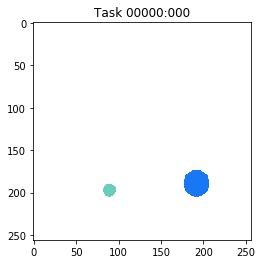

In [7]:
task_index = 0  # Note, this is a integer index of task within simulator.task_ids.
task_id = simulator.task_ids[task_index]
initial_scene = simulator.initial_scenes[task_index]
print('Initial scene shape=%s dtype=%s' % (initial_scene.shape, initial_scene.dtype))
plt.imshow(phyre.observations_to_float_rgb(initial_scene))
plt.title(f'Task {task_id}');

#### Simulation

The action space is always a unit cube, but the dimension depends on the action tier. For the ball tier, the dimensionality of the action space is 3, corresponding to the (x,y) position of the ball and its radius r. For two ball tiers the dimension is 6.

In [8]:
print('Dimension of the action space:', simulator.action_space_dim)

Dimension of the action space: 3


We can also use the simulator to sample a fixed set of random actions from the action space using `build_discrete_action_space`. The function samples actions uniformly from the action cube skipping invalid ones. The set is guaranteed to be deterministic.

In [9]:
actions = simulator.build_discrete_action_space(max_actions=100)
print('A random action:', actions[0])

A random action: [4.17022005e-01 7.20324493e-01 1.14374817e-04]


Now that we have an action, we can use the simulator to simulate it. Let's simulate it on the first task instance in our dataset. The simulator returns a **status** of the simulation (`phyre.SimulationStatus`) and intermediate observations.

In [10]:
task_index = 0  # The simulator takes an index into simulator.task_ids.
action = random.choice(actions)
# Set need_images=False to speed up simulation, when only statuses are needed.
status, images = simulator.simulate_single(task_index, action, need_images=True)
# Three statuses could be returned.
print('Action solves task:', phyre.SimulationStatus.SOLVED)
print('Action does not solve task:', phyre.SimulationStatus.NOT_SOLVED)
print('Action is an invalid input on task (e.g., occludes a task object):',
      phyre.SimulationStatus.INVALID_INPUT)
# May call is_* methods on the status to check the status.
print()
print('Result of taking action', action, 'on task', tasks[task_index], 'is:',
      status)
print('Does', action, 'solve task', tasks[task_index], '?', status.is_solved())
print('Is', action, 'an invalid action on task', tasks[task_index], '?',
      status.is_invalid())

Action solves task: SimulationStatus.SOLVED
Action does not solve task: SimulationStatus.NOT_SOLVED
Action is an invalid input on task (e.g., occludes a task object): SimulationStatus.INVALID_INPUT

Result of taking action [0.1354279  0.35570517 0.02621857] on task 00000:000 is: SimulationStatus.NOT_SOLVED
Does [0.1354279  0.35570517 0.02621857] solve task 00000:000 ? False
Is [0.1354279  0.35570517 0.02621857] an invalid action on task 00000:000 ? False


The simulator also returns a series of observations from the simulation at different timesteps. The observations are taken every second during the simulation.

Number of observations returned by simulator: 17


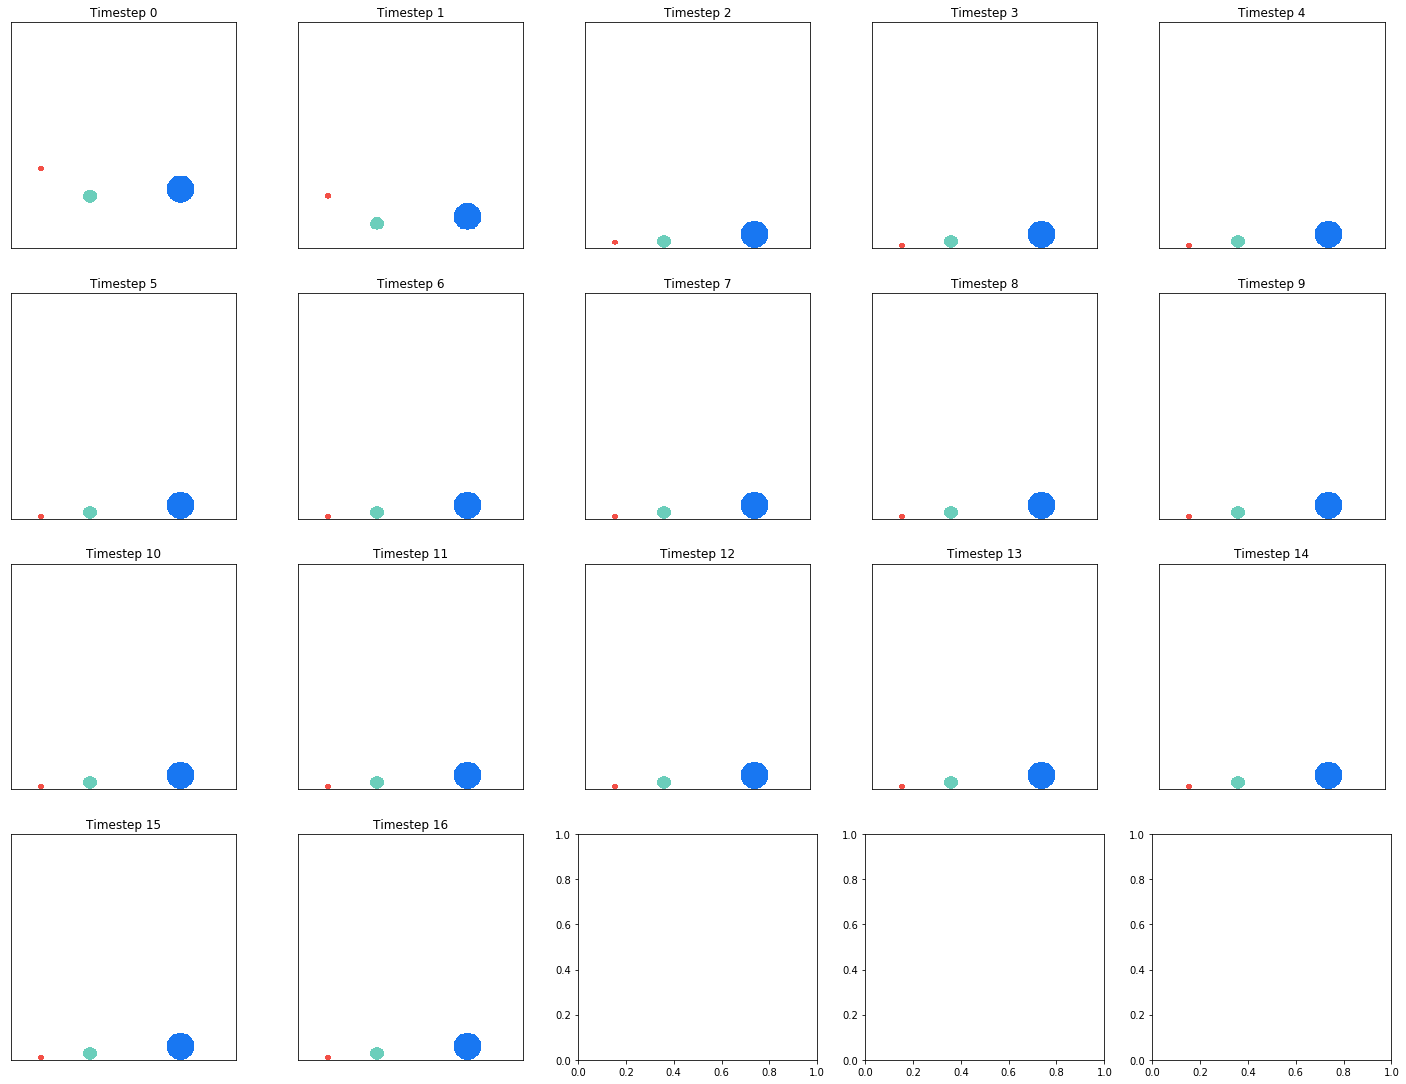

In [11]:
%matplotlib inline
print('Number of observations returned by simulator:', len(images))

num_across = 5
height = int(math.ceil(len(images) / num_across))
fig, axs = plt.subplots(height, num_across, figsize=(20, 15))
fig.tight_layout()
plt.subplots_adjust(hspace=0.2, wspace=0.2)

# We can visualize the simulation at each timestep.
for i, (ax, image) in enumerate(zip(axs.flatten(), images)):
    # Convert the simulation observation to images.
    img = phyre.observations_to_float_rgb(image)
    ax.imshow(img)
    ax.title.set_text(f'Timestep {i}')
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

Let's visualize the final state for an action that doesn't solve the task.

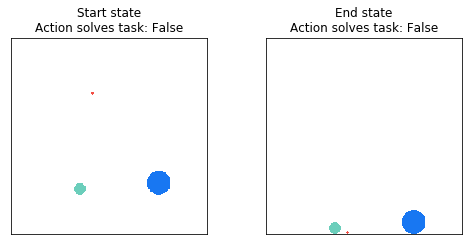

In [12]:
target_status = phyre.SimulationStatus.NOT_SOLVED if status == phyre.SimulationStatus.SOLVED else phyre.SimulationStatus.SOLVED
bad_action = actions[0]
status, images = simulator.simulate_single(task_index, bad_action, need_images=True)
assert status.is_not_solved()

# Get the start and end state of the simulation.
img_start = phyre.vis.observations_to_float_rgb(images[0])
img_end = phyre.vis.observations_to_float_rgb(images[-1])

# Visualize.
fig, axs = plt.subplots(1, 2, figsize=(7, 7))
fig.tight_layout()
plt.subplots_adjust(hspace=0.4, wspace=0.3)
axs[0].imshow(img_start)
axs[0].title.set_text(f'Start state\nAction solves task: {status.is_solved()}')
axs[0].get_xaxis().set_ticks([])
axs[0].get_yaxis().set_ticks([])

axs[1].imshow(img_end)
axs[1].title.set_text(f'End state\nAction solves task: {status.is_solved()}')
axs[1].get_xaxis().set_ticks([])
axs[1].get_yaxis().set_ticks([]);


# Part 2: Random Agent
We now build our agent. We will build the simplest agent possible: an agent that each attempt makes a random (but valid) action.

In [13]:
# We define the evaluation of this agent on a given dataset split as follows:


def evaluate_random_agent(tasks, tier):
    """Evaluates the random agent on the given tasks/tier.

    Args:
        tasks: A list of task instances (strings) in the split to evaluate.
        tier: A string of the action tier.

    Returns:
        A Evaluator object updated with the results of all the siulations.
    """

    # Create a simulator for the task and tier.
    simulator = phyre.initialize_simulator(tasks, tier)
    evaluator = phyre.Evaluator(tasks)
    assert tuple(tasks) == simulator.task_ids
    for task_index in tqdm_notebook(range(len(tasks)), desc='Evaluate tasks'):
        while evaluator.get_attempts_for_task(
                task_index) < phyre.MAX_TEST_ATTEMPTS:
            # Sample a random valid action from the simulator for the given action space.
            action = simulator.sample()
            # Simulate the given action and add the status from taking the action to the evaluator.
            status, _ = simulator.simulate_single(task_index,
                                                  action,
                                                  need_images=False)
            evaluator.maybe_log_attempt(task_index, status)
    return evaluator

Let's evaluate our agent on the dev set (for performance).

In [14]:
# NOTE: Evaluating this agent can take ~1.5 minutes.
evaluator = evaluate_random_agent(tasks, action_tier)

The metric used to compare the performance of agents is AUCESS after 100 attempts. See the PHYRE paper for more details on the AUCESS metric.

In [15]:
print('AUCESS after 100 attempts of random agent on dev set',
      evaluator.get_aucess())

AUCESS after 100 attempts of random agent on dev set 0.4472637155325895
